# Gibbs Sampling

Continuing on the same change in employees in companies example as before, we ease our assumption of fixed variance 1, instead we represent it with other Random variable as we did during the class example.

We found the Full Conditional Distribution for parameter $\mu$ as the following:-

$p(\mu | \sigma^2, y_1,....,y_n) \propto N[  \mu | \frac{n \bar y / \sigma^2 + \mu_0 / \sigma^2_0}{n/\sigma^2 + 1/ \sigma^2_0} , \frac{1}{n/\sigma^2 + 1/\sigma^2_0}]$

Similarly, the Full Conditional Distribution for the parameter $\sigma^2$ :-

$p(\sigma^2 | \mu , y_1,....,y_n) \propto InvGamma[\sigma^2 | \nu_0 + n/2, \beta_0 + \frac{\sum_{i=0}^{n} (y_i - \mu)^2}{2}]$

Let's create functions which sample from these distributions

In [1]:
update_mu = function(n, ybar, sig2, mu_0, sig2_0){
    
    new_mean = (n*ybar/sig2 + mu_0/sig2_0) / (n/sig2 + 1/sig2_0)
    new_var = 1 / (n/sig2 + 1/sig2_0)
    
    rnorm(n = 1,mean = new_mean, sd = sqrt(new_var))
    
}



update_sig2 = function(n, nu_0, beta_0, y, mu){
    
    new_shape = nu_0 + n / 2
    new_rate = beta_0 + (sum(y-mu)^2) / 2
    
    out = rgamma(n = 1, shape = new_shape, rate = new_rate)

    #Since it is Inverse Gamma
    1.0 / out
}

### Creating the Gibbs Sampler

In [2]:
Gibbs_sampler = function(y, n_iter, init, prior){
    
    #Prior Stores the Prior Hyperparameters
    
    ybar = mean(y)
    n = length(y)
    
    #This fucntion will output two vectors, one for mu and one for sigma^2
    
    mu_out = numeric(n_iter)
    sig2_out = numeric(n_iter)
    
    #To get the Gibbs sampler started, we would need to intitalize one of the parameters
    
    mu_now = init$mu
    
    
    #Loop for Gibbs Sampling Method
    
    for (i in 1:n_iter){
        
        #Since we started from mu, we will update the sigma^2 first
        sig2_now = update_sig2(n = n, y = y, mu = mu_now, nu_0 = prior$nu_0, beta_0 = prior$beta_0)
        
        mu_now = update_mu(n = n, ybar = ybar, sig2 = sig2_now, mu_0 = prior$mu_0, sig2_0 = prior$sig2_0)
        
        sig2_out[i] = sig2_now
        mu_out[i] = mu_now
    }
    
    
    #To combine to vectors intyo a matrix, use "cbind" function
    
    cbind(mu = mu_out, sig2 = sig2_out)
    
    
}

## Creating the Prior

$y_i | \mu, \sigma^2  \overset{\text{i.i.d.}}{\sim} N(\mu, \sigma^2), i = 1,....,n$

$\mu \sim N(\mu_0, \sigma^2_0)$

$\sigma^2 \sim InvGamma(\nu_0, \beta_0)$

In [3]:
y = c(1.2, 1.4, -0.5, 0.3, 0.9, 2.3, 1.0, 0.1, 1.3, 1.9)

ybar = mean(y)
n = length(y)

Creating the $\verb|Prior|$ which stores the prior hyperparameters 

In [4]:
prior = list()

prior$mu_0 = 0.0
prior$sig2_0 = 1.0


#using scaled inverse chi-squared distribution

#Prior Effective sample size
prior$n_0 = 2.0

#Prior guess for sigma^2
prior$s2_0 = 1.0



prior$nu_0 = prior$n_0 / 2.0
prior$beta_0 = prior$n_0 * prior$s2_0 / 2.0

#### Let's take a look at Prior Distribution before running the Gibbs Sampler

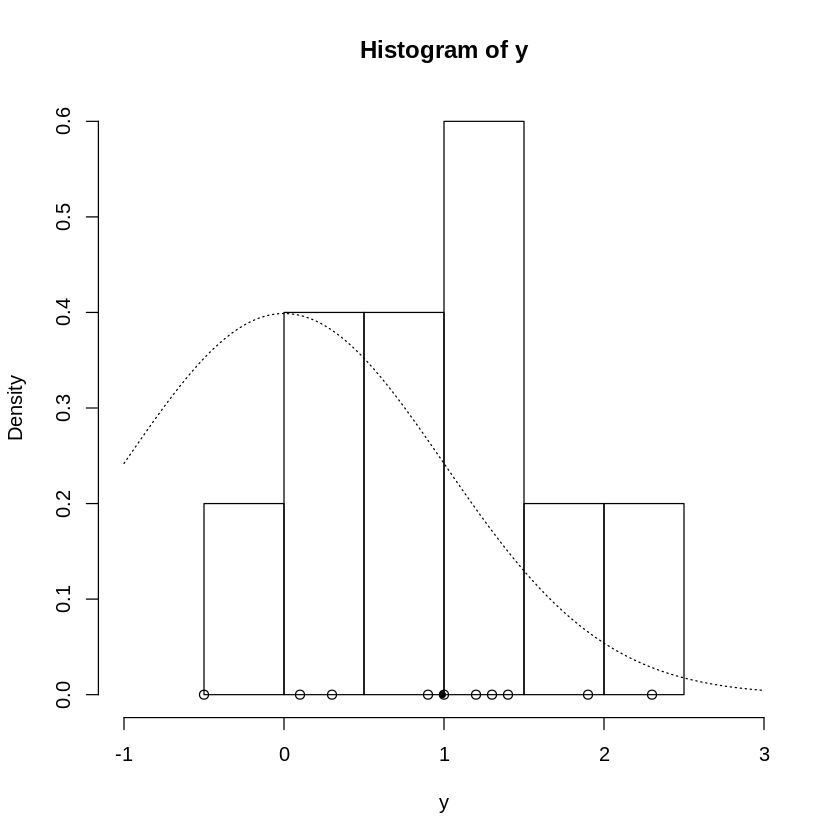

In [6]:
hist(y, freq = FALSE, xlim = c(-1,3))
points(y, rep(x = 0.0, n))
points(ybar, 0, pch = 20)


#prior distribution for the mean (mu)

curve(dnorm(x = x, mean = prior$mu_0, sd = sqrt(prior$sig2_0)), lty = 3, add =TRUE)

## Running the Gibbs Sampler

In [10]:
set.seed(53)

In [11]:
init = list()

init$mu = 0.0

In [12]:
posterior_distrib = Gibbs_sampler(y = y, n_iter = 1000, init = init, prior = prior)

In [13]:
head(posterior_distrib)

mu,sig2
-0.3622184,8.3640010
-0.7013576,12.9978896
-1.3330595,38.0380174
0.8741329,48.5301129
1.0151601,0.3280962
1.0939263,0.1958496


In [14]:
tail(posterior_distrib)

,mu,sig2
"[995,]",0.8972428,0.1358110
"[996,]",0.9907625,0.2478898
"[997,]",0.9126262,0.1110516
"[998,]",0.9826874,0.2524256
"[999,]",0.9676634,0.1962903
"[1000,]",0.9856490,0.2205251


In [15]:
library("coda")

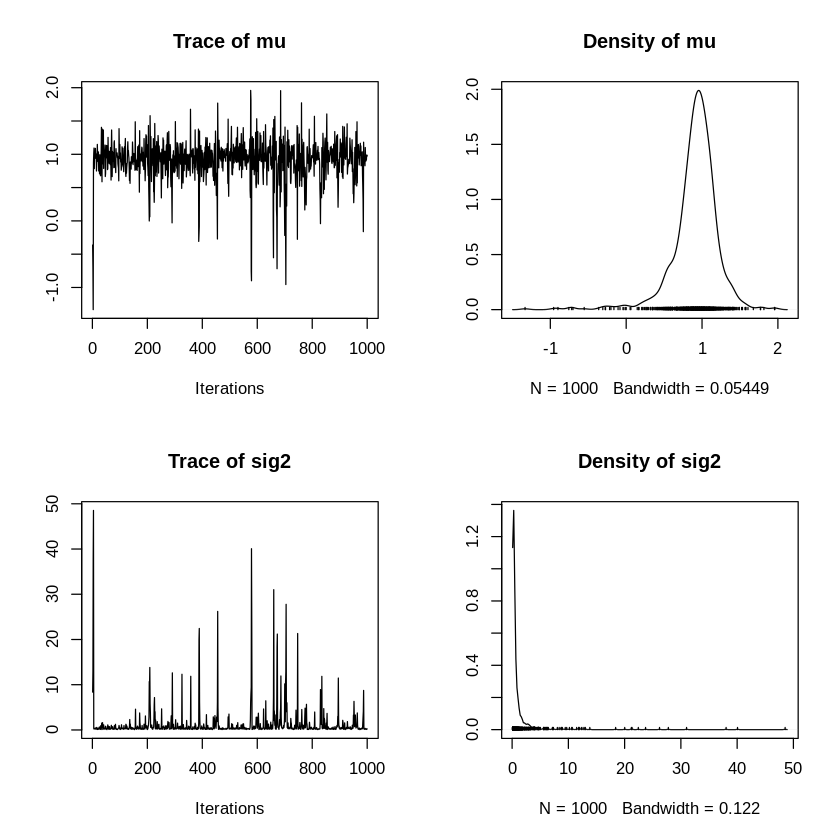

In [16]:
plot(as.mcmc(posterior_distrib))

In [17]:
summary(as.mcmc(posterior_distrib))


Iterations = 1:1000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 1000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

       Mean     SD Naive SE Time-series SE
mu   0.9106 0.3077  0.00973        0.01245
sig2 1.2599 3.5818  0.11327        0.18508

2. Quantiles for each variable:

       2.5%    25%    50%    75% 97.5%
mu   0.2041 0.8001 0.9427 1.0744 1.406
sig2 0.1083 0.2178 0.3633 0.8319 9.452


It seems that the Chains have appeared to converge, we will see in the later lessons how to concretely determine that.

#### Quiz Question 7 & 8

In [18]:
y = c(-0.2, -1.5, -5.3, 0.3, -0.8, -2.2)

In [20]:
posterior_distrib = Gibbs_sampler(y = y, n_iter = 5000, init = init, prior = prior) 

In [21]:
summary(posterior_distrib)

       mu              sig2          
 Min.   :-2.976   Min.   :  0.08645  
 1st Qu.:-1.645   1st Qu.:  0.33918  
 Median :-1.438   Median :  0.67142  
 Mean   :-1.319   Mean   :  2.51378  
 3rd Qu.:-1.140   3rd Qu.:  1.76029  
 Max.   : 1.821   Max.   :205.61739  

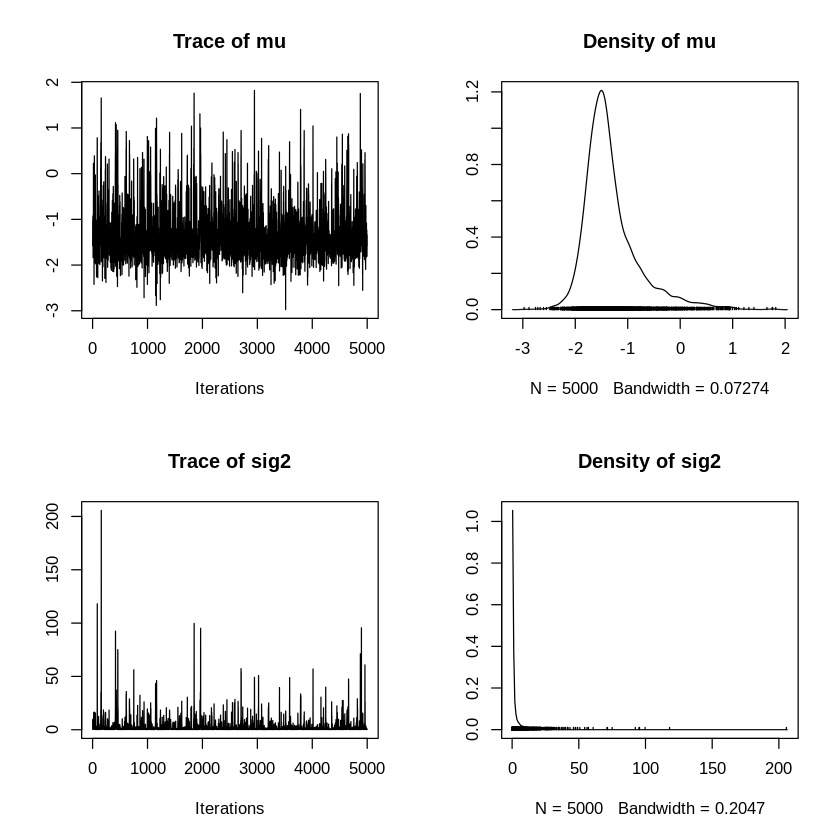

In [22]:
plot(as.mcmc(posterior_distrib))

In [23]:
prior

$mu_0
[1] 0

$sig2_0
[1] 1

$n_0
[1] 2

$s2_0
[1] 1

$nu_0
[1] 1

$beta_0
[1] 1

In [24]:
prior$mu_0 = 1

In [25]:
prior

$mu_0
[1] 1

$sig2_0
[1] 1

$n_0
[1] 2

$s2_0
[1] 1

$nu_0
[1] 1

$beta_0
[1] 1

In [26]:
posterior_distrib = Gibbs_sampler(y = y, n_iter = 5000, init = init, prior = prior) 

In [27]:
summary(posterior_distrib)

       mu               sig2         
 Min.   :-3.3453   Min.   :  0.0746  
 1st Qu.:-1.3563   1st Qu.:  0.7654  
 Median :-0.7348   Median :  4.1567  
 Mean   :-0.4865   Mean   : 14.6643  
 3rd Qu.: 0.2455   3rd Qu.: 17.3401  
 Max.   : 4.0024   Max.   :743.8441  

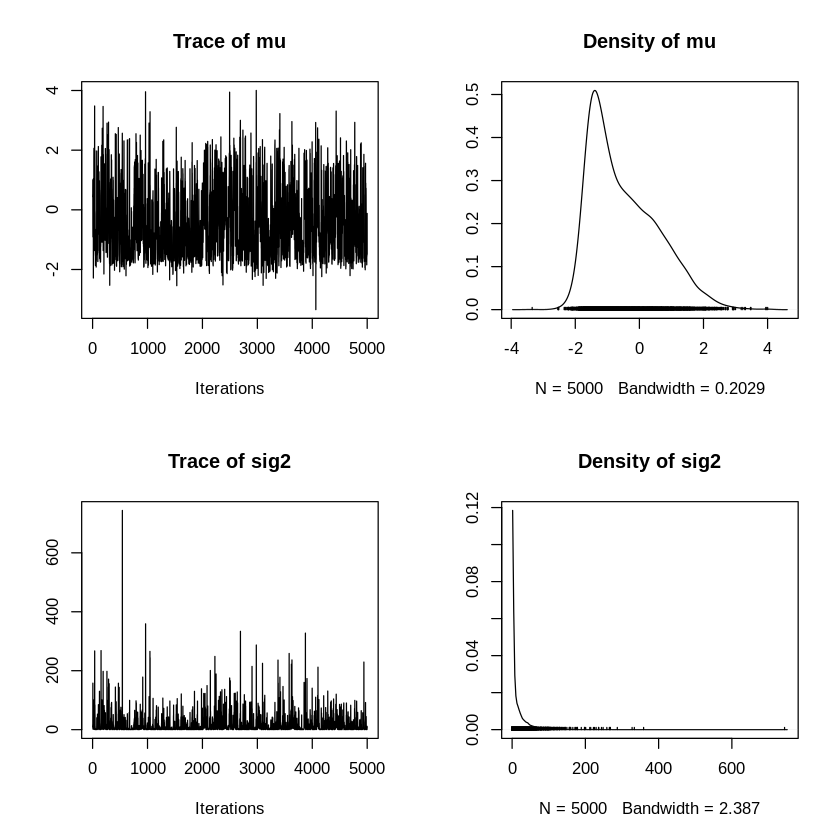

In [28]:
plot(as.mcmc(posterior_distrib))